In [1]:
# ============================
# 1. Imports
# ============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm


In [2]:
# ============================
# 2. Dataset & Dataloaders (Fixed Split + Transforms)
# ============================

# Define transforms first
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),           # resize for InceptionV1
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),           # same size for validation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Path to dataset
data_dir = "/kaggle/input/cucumber-disease/cucumber_disease"

# Load dataset (no transform yet, just to get classes & indices)
full_dataset = datasets.ImageFolder(data_dir)
class_names = full_dataset.classes

# Train/Val split (70/30)
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # reproducibility
)

# Apply transforms to each split
train_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(data_dir, transform=val_transform)

# Restrict datasets to the split indices
train_dataset = torch.utils.data.Subset(train_dataset, train_subset.indices)
val_dataset   = torch.utils.data.Subset(val_dataset, val_subset.indices)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Check dataset info
print("Classes:", class_names)
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")


Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Pythium Fruit Rot']
Train samples: 790, Val samples: 339


In [3]:
import torch
import torch.nn as nn
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Load pretrained EfficientNetV2-B3
# -----------------------------
model = timm.create_model("tf_efficientnetv2_b3", pretrained=True)

# -----------------------------
# Freeze all layers
# -----------------------------
for param in model.parameters():
    param.requires_grad = False

# -----------------------------
# Unfreeze last 30% layers
# -----------------------------
layers = list(model.children())[:-1]  # exclude classifier
num_layers = len(layers)
unfreeze_from = int(num_layers * 0.7)

for layer in layers[unfreeze_from:]:
    for param in layer.parameters():
        param.requires_grad = True

# -----------------------------
# Replace classifier
# -----------------------------
num_classes = 7
in_features = model.get_classifier().in_features   # timm handles input size
model.reset_classifier(num_classes=num_classes)   # safe replacement

model = model.to(device)

# -----------------------------
# Loss & Optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=0.0001
)


model.safetensors:   0%|          | 0.00/57.9M [00:00<?, ?B/s]

In [4]:
# ============================
# 4. Training & Validation Loop (MobileNetV2 + tqdm + EarlyStopping)
# ============================
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_epochs = 15
patience = 5  # stop if no improvement after 5 epochs

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

best_val_acc = 0.0
best_val_loss = float("inf")
early_stop_counter = 0

# -----------------------------
# Add Scheduler (Reduce LR on Plateau)
# -----------------------------
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",     # minimize validation loss
    factor=0.1,     # reduce LR by 10x
    patience=3,     # wait 3 epochs before reducing LR
    verbose=True
)

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss, correct, total = 0, 0, 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = 100 * correct / total

    # ---- Validation ----
    model.eval()
    running_loss, correct, total = 0, 0, 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)

    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            val_pbar.set_postfix(loss=loss.item())

    val_loss = running_loss / total
    val_acc = 100 * correct / total

    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Step scheduler with validation loss
    scheduler.step(val_loss)

    # Save best model (based on val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_mobilenetv2.pth")
        early_stop_counter = 0  # reset patience
    else:
        early_stop_counter += 1

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping
    if early_stop_counter >= patience:
        print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}")
        break

print(f"\nTraining complete. Best Validation Accuracy: {best_val_acc:.2f}%")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/15] Train Loss: 1.8123, Train Acc: 31.77% Val Loss: 1.6029, Val Acc: 42.77%


Epoch [2/15] Train Loss: 1.3679, Train Acc: 60.25% Val Loss: 1.2593, Val Acc: 67.85%


Epoch [3/15] Train Loss: 1.0900, Train Acc: 71.65% Val Loss: 1.0232, Val Acc: 79.35%


Epoch [4/15] Train Loss: 0.9005, Train Acc: 78.23% Val Loss: 0.8649, Val Acc: 83.48%


Epoch [5/15] Train Loss: 0.7563, Train Acc: 83.54% Val Loss: 0.7468, Val Acc: 86.73%


Epoch [6/15] Train Loss: 0.6530, Train Acc: 86.71% Val Loss: 0.6578, Val Acc: 87.91%


Epoch [7/15] Train Loss: 0.5897, Train Acc: 86.20% Val Loss: 0.5914, Val Acc: 89.68%


Epoch [8/15] Train Loss: 0.5279, Train Acc: 87.34% Val Loss: 0.5413, Val Acc: 90.86%


Epoch [9/15] Train Loss: 0.4938, Train Acc: 89.87% Val Loss: 0.5095, Val Acc: 91.45%


Epoch [10/15] Train Loss: 0.4510, Train Acc: 90.25% Val Loss: 0.4749, Val Acc: 91.45%


Epoch [11/15] Train Loss: 0.4097, Train Acc: 92.66% Val Loss: 0.4424, Val Acc: 91.45%


Epoch [12/15] Train Loss: 0.3939, Train Acc: 91.14% Val Loss: 0.4197, Val Acc: 91.74%


Epoch [13/15] Train Loss: 0.3477, Train Acc: 92.91% Val Loss: 0.3913, Val Acc: 91.74%


Epoch [14/15] Train Loss: 0.3664, Train Acc: 90.76% Val Loss: 0.3842, Val Acc: 91.74%


Epoch [15/15] Train Loss: 0.3176, Train Acc: 93.80% Val Loss: 0.3584, Val Acc: 92.33%

Training complete. Best Validation Accuracy: 92.33%


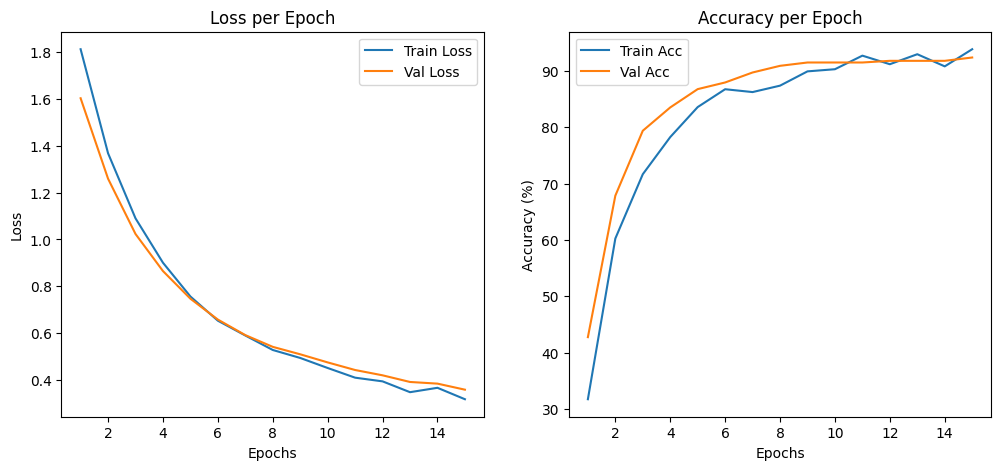

In [5]:
# ============================
# 5. Training History Plots
# ============================
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch")
plt.legend()

plt.show()


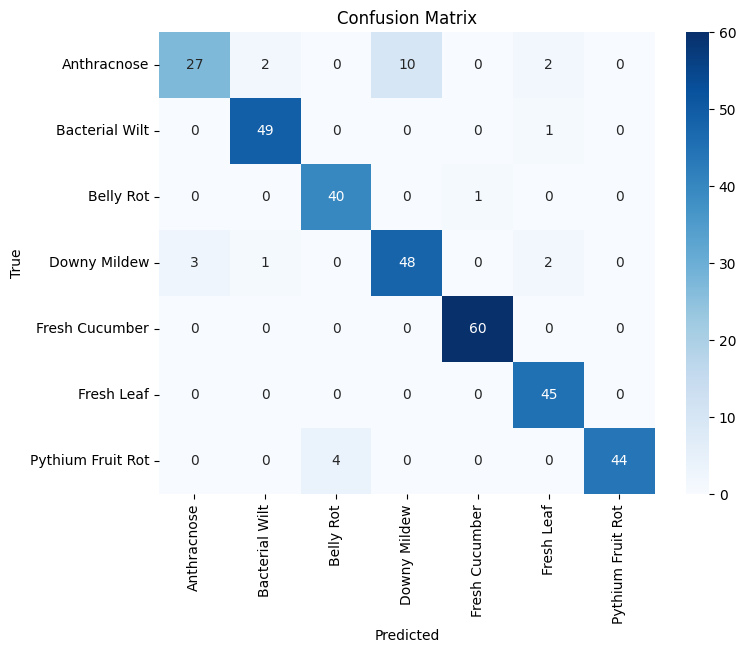


Classification Report:

                   precision    recall  f1-score   support

      Anthracnose       0.90      0.66      0.76        41
   Bacterial Wilt       0.94      0.98      0.96        50
        Belly Rot       0.91      0.98      0.94        41
     Downy Mildew       0.83      0.89      0.86        54
   Fresh Cucumber       0.98      1.00      0.99        60
       Fresh Leaf       0.90      1.00      0.95        45
Pythium Fruit Rot       1.00      0.92      0.96        48

         accuracy                           0.92       339
        macro avg       0.92      0.92      0.92       339
     weighted avg       0.92      0.92      0.92       339



In [6]:
# ============================
# 6. Evaluation: Confusion Matrix & Report
# ============================
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
